In [194]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import math
from tensorflow.python.framework import ops
from sklearn import preprocessing
%run helpers.ipynb
%matplotlib inline

In [395]:
df = pd.read_csv('bank-additional-full.csv', header = 0)

In [396]:
df.head(4)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [397]:
# Data preparation

# Not sure if I should keep the data on jobs since numerical representation isn't optimal.
# idea: let each job category be its own feature, which will be represented as a 1 or 0, for yes or no.

# add columns with binary indicator variables for job type
df = createJobColumns(df)
df = df.drop('job', 1)

# add columns with binary indicator variables for marital status
df = createMaritalColumns(df)
df = df.drop('marital', 1)

# add columns with binary indicator variables for education level
df = createEducationColumns(df)
df = df.drop('education', 1)

# for "unknown" values of "default", input the average value of the default column.
# in dataset, 3 values = yes, 32588 values = no, 8597 values = unknown.
# can verify this with -> print(df['default'].value_counts())
# 3 / (3+32588) = 0.00009204995
df['default'] = df['default'].map({'yes': 1, 'no': 0, 'unknown': 0.00009204995})

# housing : has housing loan? Yes, no, unknown. Set unknown to average value.
# print(df['housing'].value_counts())
# yes : 21576, no : 18622, unknown : 990. (21576 / (21576 + 18622)) = 0.53674312154
df['housing'] = df['housing'].map({'yes': 1, 'no': 0, 'unknown': 0.53674312154})

# loan : has personal loan? Yes, no, unknown. Set unknown to average value.
# print(df['loan'].value_counts())
# yes : 6248, no : 33950, unknown : 990. (6428 / (6248 + 33950)) =  0.15990845315
df['loan'] = df['loan'].map({'yes': 1, 'no': 0, 'unknown': 0.15990845315})

# contact : telephone or cellular
df['contact'] = df['contact'].map({'telephone': 1, 'cellular': 0})

# discard "month", "day_of_week", "duration", "campaign", "pdays" columns.
df = df.drop('month', 1)
df = df.drop('day_of_week', 1)
df = df.drop('duration', 1)
df = df.drop('campaign', 1)
df = df.drop('pdays', 1)

# add columns with binary indicator variables for poutcome: outcome of previous marketing campaign
df = createPOutcomeColumns(df)
df = df.drop('poutcome', 1)

# normalize the age column
df['age'] = (df['age'] - df['age'].mean()) / df['age'].std()

# normalize the employment variation rate column
df['emp.var.rate'] = (df['emp.var.rate'] - df['emp.var.rate'].mean()) / df['emp.var.rate'].std()

# normalize the consumer price index column
df['cons.price.idx'] = (df['cons.price.idx'] - df['cons.price.idx'].mean()) / df['cons.price.idx'].std()

# normalize the consumer confidence index column
df['cons.conf.idx'] = (df['cons.conf.idx'] - df['cons.conf.idx'].mean()) / df['cons.conf.idx'].std()

# normalize the euribor 3 month date column
df['euribor3m'] = (df['euribor3m'] - df['euribor3m'].mean()) / df['euribor3m'].std()

# normalize the number of employees column
df['nr.employed'] = (df['nr.employed'] - df['nr.employed'].mean()) / df['nr.employed'].std()


df = df.sample(frac=1) # shuffle the rows

# get output vector
Y = df['y']
Y = Y.map({'yes': 1, 'no': 0})

# drop output from input matrix
df = df.drop('y', 1)


# 41188 examples, 37 features
# 594 in cv & test set. 40,000 in train

X_train = df.iloc[0:40000,:]    # first 40,000 rows
X_cv = df.iloc[40000:40594,:]   # next 594 rows
X_test = df.iloc[40594:41188,:] # next 594 rows

Y_train = Y.iloc[0:40000]
Y_cv = Y.iloc[40000:40594]
Y_test = Y.iloc[40594:41188]

# convert to numpy arrays
X_train = X_train.values.T
X_cv = X_cv.values.T
X_test = X_test.values.T
Y_train = Y_train.values.T
Y_cv = Y_cv.values.T
Y_test = Y_test.values.T


Y_train.shape = (1,40000)
Y_cv.shape = (1,594)
Y_test.shape = (1,594)

print ("number of training examples = " + str(X_train.shape[1])) 
print ("number of cv examples = " + str(X_cv.shape[1])) 
print ("number of test examples = " + str(X_test.shape[1]))
print ("X_train shape: " + str(X_train.shape)) 
print ("Y_train shape: " + str(Y_train.shape)) 
print ("X_test shape: " + str(X_test.shape)) 
print ("Y_test shape: " + str(Y_test.shape))
print ("X_cv shape: " + str(X_cv.shape)) 
print ("Y_cv shape: " + str(Y_cv.shape))
df

number of training examples = 40000
number of cv examples = 594
number of test examples = 594
X_train shape: (36, 40000)
Y_train shape: (1, 40000)
X_test shape: (36, 594)
Y_test shape: (1, 594)
X_cv shape: (36, 594)
Y_cv shape: (1, 594)


,age,default,housing,loan,contact,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,...,basic.4y,basic.6y,high.school,basic.9y,illiterate,professional.course,university.degree,Psuccess,Pfailure,Pnonexistent
21672,0.381522,0.000092,1.000000,1.000000,0,0,0.839050,-0.227462,0.951256,0.773566,...,0,0,0,1,0,0,0,0,0,1
12429,-0.961887,0.000000,0.000000,0.000000,0,0,0.839050,0.591417,-0.474785,0.771836,...,0,0,0,0,0,0,1,0,0,1
33221,-0.194224,0.000092,0.000000,0.000000,0,0,-1.197921,-1.179366,-1.231019,-1.343535,...,0,0,0,0,0,0,0,0,0,1
27,-0.098267,0.000092,0.000000,0.000000,1,0,0.648084,0.722714,0.886436,0.712451,...,0,0,0,1,0,0,0,0,0,1
7771,0.477480,0.000000,0.000000,0.000000,1,0,0.839050,1.536410,-0.280325,0.717064,...,0,0,0,1,0,0,0,0,0,1
6960,-0.194224,0.000000,1.000000,0.000000,1,0,0.648084,0.722714,0.886436,0.714181,...,0,0,0,1,0,0,0,0,0,1
1041,1.628973,0.000000,0.000000,0.000000,1,0,0.648084,0.722714,0.886436,0.711875,...,0,0,1,0,0,0,0,0,0,1
1751,-1.057844,0.000000,0.000000,0.000000,1,0,0.648084,0.722714,0.886436,0.711298,...,0,0,1,0,0,0,0,0,0,1
19333,1.149185,0.000000,1.000000,1.000000,0,0,0.839050,-0.227462,0.951256,0.775872,...,0,0,0,0,0,0,1,0,0,1
30903,-1.057844,0.000000,1.000000,0.000000,0,1,-1.197921,-1.179366,-1.231019,-1.312978,...,0,0,0,0,0,0,1,0,1,0


In [398]:
def create_placeholders(n_x, n_y):
    X = tf.placeholder(tf.float32, [n_x, None])
    Y = tf.placeholder(tf.float32, [n_y, None])
    return X,Y

def initialize_parameters():
    # input layer      : 36 nodes
    # 1st hidden layer : 30 nodes
    # 2nd hidden layer : 25 nodes
    # 3rd hidden layer : 20 nodes
    # 4th hidden layer : 15 nodes
    # 5th hidden layer : 10 nodes
    # 6th hidden layer : 5 nodes
    # output layer     : 1 node
    
    W1 = tf.get_variable('W1', [30,36], initializer = tf.contrib.layers.xavier_initializer())
    b1 = tf.get_variable('b1', [30,1], initializer = tf.zeros_initializer())
    W2 = tf.get_variable('W2', [25,30], initializer = tf.contrib.layers.xavier_initializer())
    b2 = tf.get_variable('b2', [25,1], initializer = tf.zeros_initializer())
    W3 = tf.get_variable('W3', [20,25], initializer = tf.contrib.layers.xavier_initializer())
    b3 = tf.get_variable('b3', [20,1], initializer = tf.zeros_initializer())
    W4 = tf.get_variable('W4', [15,20], initializer = tf.contrib.layers.xavier_initializer())
    b4 = tf.get_variable('b4', [15,1], initializer = tf.zeros_initializer())
    W5 = tf.get_variable('W5', [10,15], initializer = tf.contrib.layers.xavier_initializer())
    b5 = tf.get_variable('b5', [10,1], initializer = tf.zeros_initializer())
    W6 = tf.get_variable('W6', [5,10], initializer = tf.contrib.layers.xavier_initializer())
    b6 = tf.get_variable('b6', [5,1], initializer = tf.zeros_initializer())
    W7 = tf.get_variable('W7', [1,5], initializer = tf.contrib.layers.xavier_initializer())
    b7 = tf.get_variable('b7', [1,1], initializer = tf.zeros_initializer())

    
    parameters = {'W1': W1,
                 'b1': b1,
                 'W2': W2,
                 'b2': b2,
                 'W3': W3,
                 'b3': b3,
                 'W4': W4,
                 'b4': b4,
                 'W5': W5,
                 'b5': b5,
                 'W6': W6,
                 'b6': b6,
                 'W7': W7,
                 'b7': b7}
    return parameters

def forward_propagation(X, parameters):
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    W4 = parameters['W4']
    b4 = parameters['b4']
    W5 = parameters['W5']
    b5 = parameters['b5']
    W6 = parameters['W6']
    b6 = parameters['b6']
    W7 = parameters['W7']
    b7 = parameters['b7']
    
    Z1 = tf.add(tf.matmul(W1,X), b1)
    A1 = tf.nn.relu(Z1)
    Z2 = tf.add(tf.matmul(W2,A1), b2)
    A2 = tf.nn.relu(Z2)
    Z3 = tf.add(tf.matmul(W3,A2), b3)
    A3 = tf.nn.relu(Z3)
    Z4 = tf.add(tf.matmul(W4,A3), b4)
    A4 = tf.nn.relu(Z4)
    Z5 = tf.add(tf.matmul(W5,A4), b5)
    A5 = tf.nn.relu(Z5)
    Z6 = tf.add(tf.matmul(W6,A5), b6)
    A6 = tf.nn.relu(Z6)
    Z7 = tf.add(tf.matmul(W7,A6), b7)
    
    return Z7

def compute_cost(Z7, Y, parameters):
    logits = tf.transpose(Z7)
    labels = tf.transpose(Y)
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    W4 = parameters['W4']
    b4 = parameters['b4']
    W5 = parameters['W5']
    b5 = parameters['b5']
    W6 = parameters['W6']
    b6 = parameters['b6']
    W7 = parameters['W7']
    b7 = parameters['b7']
    # b's not used in regularization cost
    
    cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = logits, labels = labels))
    
    #L2_regularization_cost = np.sum(np.square(W1)) + np.sum(np.square(W2)) + np.sum(np.square(W3))
    
    # maybe increase beta a bit more since this model overfits more than the 2 layer one
    beta = 0.00

    regularizers = tf.nn.l2_loss(W1) + tf.nn.l2_loss(W2) + tf.nn.l2_loss(W3) +  tf.nn.l2_loss(W4) + tf.nn.l2_loss(W5) + tf.nn.l2_loss(W6) + tf.nn.l2_loss(W7)
    cost = tf.reduce_mean(cost + beta*regularizers)
    
    #cost = cost + L2_regularization_cost
    return cost

def random_mini_batches(X, Y, mini_batch_size = 64):
    m = X.shape[1]                  # number of training examples
    mini_batches = []
    
    # shuffle X and Y
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((Y.shape[0],m))

    
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # last batch
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch_Y = shuffled_Y[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [399]:
def model(X_train, Y_train, X_test, Y_test, X_cv, Y_cv, learning_rate = 0.3,
         num_epochs = 2000, minibatch_size = 64, print_cost = True):
    
    ops.reset_default_graph()
    (n_x,m) = X_train.shape
    n_y = Y_train.shape[0]
    costs = []
    
    X, Y = create_placeholders(n_x,n_y)
    parameters = initialize_parameters()
    Z7 = forward_propagation(X, parameters)
    cost = compute_cost(Z7,Y, parameters)
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
    
    init = tf.global_variables_initializer()
    
    with tf.Session() as sess:
        sess.run(init)
        for epoch in range(num_epochs):
            epoch_cost = 0
            num_minibatches = int(m/minibatch_size)
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size)
            
            for minibatch in minibatches:
                (minibatch_X, minibatch_Y) = minibatch
                _, minibatch_cost = sess.run([optimizer, cost], feed_dict={X:minibatch_X, Y:minibatch_Y})
                epoch_cost += minibatch_cost / num_minibatches
            if print_cost == True and epoch % 100 == 0:
                print('Epoch %i cost: %f' % (epoch, epoch_cost))
            if print_cost == True and epoch % 5 == 0 and epoch >= 0:
                costs.append(epoch_cost)
        
        plt.plot(np.squeeze(costs),lw=0.5)
        plt.ylabel('cost')
        plt.xlabel('epoch')
        plt.title('Learning rate='+str(learning_rate))
        
        parameters = sess.run(parameters)
        print('parameters trained')
        
        
        correct_prediction = tf.equal(tf.round(tf.sigmoid(Z7)), tf.round(Y))
        
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, 'float'))
        
        print("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train}))
        print("Cross_val Accuracy:", accuracy.eval({X: X_cv, Y: Y_cv}))
        print("Test Accuracy:",  accuracy.eval({X: X_test, Y: Y_test}))
        
        '''# check predictions to make sure it doesn't always guess the same outcome
        prediction = tf.round(tf.sigmoid(Z7))
        print(prediction.eval(feed_dict={X: X_cv}))
        
        # labelled outcomes
        actual = tf.round(Y)
        print(actual.eval(feed_dict={Y: Y_cv}))'''
        
        return parameters

Epoch 0 cost: 0.726396
Epoch 100 cost: 0.307685
Epoch 200 cost: 0.288710
Epoch 300 cost: 0.283110
Epoch 400 cost: 0.279511
Epoch 500 cost: 0.277433
Epoch 600 cost: 0.275930
Epoch 700 cost: 0.274478
Epoch 800 cost: 0.272849
Epoch 900 cost: 0.271081
Epoch 1000 cost: 0.269354
Epoch 1100 cost: 0.267687
Epoch 1200 cost: 0.266250
Epoch 1300 cost: 0.264961
Epoch 1400 cost: 0.263780
Epoch 1500 cost: 0.262687
Epoch 1600 cost: 0.261603
Epoch 1700 cost: 0.260637
Epoch 1800 cost: 0.259715
Epoch 1900 cost: 0.258901
parameters trained
Train Accuracy: 0.907475
Cross_val Accuracy: 0.90404
Test Accuracy: 0.878788


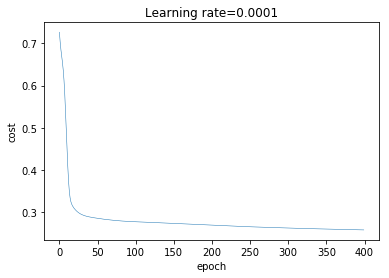

In [400]:
#Train Accuracy: 0.907475
#Cross_val Accuracy: 0.90404
#Test Accuracy: 0.878788
# 2k iterations
parameters = model(X_train, Y_train, X_test, Y_test, X_cv, Y_cv, learning_rate = 0.0001, minibatch_size=8000)

# Train Accuracy: 0.899525
# Cross_val Accuracy: 0.919192
# Test Accuracy: 0.882155
# 2k iterations
# parameters = model(X_train, Y_train, X_test, Y_test, X_cv, Y_cv, learning_rate = 0.0001, minibatch_size=40000)

# Train Accuracy: 0.9013
# Cross_val Accuracy: 0.890572
# Test Accuracy: 0.912458
# 200 iterations, batch size =  400, beta = 0.001
#parameters = model(X_train, Y_train, X_test, Y_test, X_cv, Y_cv, learning_rate = .001, minibatch_size=400)

# can't seem to get better than 92% accuracy with this model.


In [401]:
print(parameters)

{'W1': array([[-0.05893714,  0.34781039,  0.15840891, ...,  0.2470426 ,
        -0.03005595,  0.32082161],
       [-0.15675975, -0.43268433, -0.03126655, ..., -0.05882883,
         0.06529742, -0.24034168],
       [-0.12372818,  0.59037906, -0.01300898, ...,  0.01710478,
         0.18182068,  0.22161463],
       ..., 
       [-0.25666386, -0.0155133 , -0.27162185, ..., -0.27871066,
        -0.16481362,  0.35319066],
       [-0.31064507, -0.12317338,  0.14936987, ..., -0.13830796,
         0.23693137, -0.18008402],
       [-0.04639789, -0.24788116,  0.06181968, ..., -0.23516516,
         0.12423296,  0.12418099]], dtype=float32), 'b1': array([[ 0.02349415],
       [-0.11454388],
       [ 0.06168686],
       [ 0.08077939],
       [-0.03618613],
       [-0.03334953],
       [ 0.01049779],
       [ 0.05755832],
       [-0.01655069],
       [ 0.0167005 ],
       [ 0.0182493 ],
       [ 0.13677476],
       [ 0.01035193],
       [ 0.05966811],
       [ 0.06097437],
       [ 0.05444001],
     